In [42]:
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt
import matplotlib as mpl


from functions import s_SM, neq_stable, get_relic_abundance
from scipy.special import kve

mpl.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": 12,
})

In [ ]:
# ----------------------------
# Cosmology helpers (RD epoch)
# ----------------------------
MPL_REDUCED_GEV = 2.435e18  # reduced Planck mass in GeV
MPL   = 1.2209e19

# def H_RD(T, gstar):
#     """
#     Hubble rate during radiation domination, H \approx 1.66 * sqrt(g*) * T^2 / Mpl
#     """
#     return 1.66 * np.sqrt(gstar) * T**2 / MPL_REDUCED_GEV

# def t_of_T_RD(T, gstar):
#     """
#     time-temperature relation in RD: t ~ 0.301 * Mpl / (sqrt(g*) T^2)
#     """
#     return 0.301 * MPL_REDUCED_GEV / (np.sqrt(gstar) * T**2)



###########
# def H_RD(T, gstar):
#     return np.sqrt(np.pi**2 * gstar / 90.0) * T**2 / MPL_REDUCED_GEV

def H_RD(T, gstar, rho_h=0.0, include_hs = False):
    """Hubble from SM  + HS """
    ## typically by freezeout, all radiation energy has been deposited into non-rel species
    ## technically more correct to include
    rho_SM = (np.pi**2/30.0) * gstar * T**4
    if include_hs:
        rho_tot = rho_SM + rho_h
    else:
        rho_tot = rho_SM
    return np.sqrt((8.0*np.pi/3.0) * rho_tot) / MPL


def t_of_T_RD(T, gstar):
    return 1.0 / (2.0 * H_RD(T, gstar))

@dataclass
class PhaseSpaceSpecies:
    name: str
    mass_GeV: float
    dof: float
    decay_width_GeV: float = 0.0
    # f stored as f(p_tilde) at the grid points

class PhaseSpaceGrid:
    """
    Log-spaced comoving momentum grid: p_tilde = a(t) * p_phys
    """
    def __init__(self, ptilde_min, ptilde_max, Np, T_ref):
        assert ptilde_min > 0
        self.ptilde = np.geomspace(ptilde_min, ptilde_max, Np)  # comoving momentum bins
        self.log_ptilde = np.log(self.ptilde)
        # self.dlogp = np.diff(self.log_ptilde)  # length Np-1
        edges = np.zeros(Np + 1)
        edges[1:-1] = 0.5 * (self.log_ptilde[1:] + self.log_ptilde[:-1])
        edges[0] = self.log_ptilde[0] - (edges[1] - self.log_ptilde[0])
        edges[-1] = self.log_ptilde[-1] + (self.log_ptilde[-1] - edges[-2])

        self.dlogp = np.diff(edges)  # length Np
        self.T_ref = float(T_ref)
        self._Np = Np

    def a_of_T(self, T, gstar_s_ratio=1.0):
        #return 1
        # gstar_s_ratio = gstar_s(T_ref) / gstar_s(T) (i.e. entropy dilution factor)
        return (self.T_ref / T) * (gstar_s_ratio)**(1.0/3.0)

    def p_phys(self, T, gstar_s_ratio=1.0):
        """physical momentum at temperature T corresponding to each p_tilde bin."""
        a = self.a_of_T(T, gstar_s_ratio=gstar_s_ratio)
        return self.ptilde / a

class PhaseSpaceState:
    """
    holds f(ptilde) for multiple species AND evolves in time
    """
    def __init__(self, grid: PhaseSpaceGrid, species: list[PhaseSpaceSpecies]):
        self.grid = grid
        self.species = {sp.name: sp for sp in species}
        self.f = {sp.name: np.zeros_like(grid.ptilde) for sp in species}
        self.ann_kernel = None
        self.mpsi_GeV = None
        self.Msq_const = None
        self.Nmu = 8
        self.Nt = 8
        self.mf_GeV = None
        self.K_grid = None
        self.T_grid = None


    def set_initial_f(self, name, f_ptilde):
        f_ptilde = np.asarray(f_ptilde, dtype=float)
        assert f_ptilde.shape == self.f[name].shape
        self.f[name] = f_ptilde.copy()

    def evolve_free_streaming(self, T_grid):
        """
        With comoving momentum bins, free streaming keeps f(ptilde) invariant:
          df/dt = 0  => f is constant in time.
        """
        T_grid = np.asarray(T_grid, dtype=float)
        snapshots = []
        for T in T_grid:
            snapshots.append({k: v.copy() for k, v in self.f.items()})
        return snapshots

    # ----------------------------
    # Derived quantities
    # ----------------------------
    def number_density(self, name, T):
        """
        n = g/(2pi^2) int( dp p^2 f(p))
        """
        sp = self.species[name]
        p = self.grid.p_phys(T)
        f_p = self.f[name]
        # integrate over p using trapezoid
        integrand = p**2 * f_p
        n = sp.dof / (2.0 * np.pi**2) * np.trapezoid(integrand, p)
        return n

    # def number_density(self, name, T):
    #     sp = self.species[name]
    #     p = self.grid.p_phys(T)
    #     f = self.f[name]
    #     n = sp.dof / (2.0 * np.pi**2) * np.sum(p**3 * f * self.grid.dlogp)
    #     return n

    def energy_density(self, name, T):
        """
        ρ = g/(2pi^2) int(dp p^2 E(p) f(p)), with E = sqrt(p^2 + m^2)
        """
        sp = self.species[name]
        p = self.grid.p_phys(T)
        E = np.sqrt(p**2 + sp.mass_GeV**2)
        f_p = self.f[name]
        integrand = p**2 * E * f_p
        rho = sp.dof / (2.0 * np.pi**2) * np.trapezoid(integrand, p)
        return rho

In [119]:
# # Setup
T_ref = 100.0  # GeV
grid = PhaseSpaceGrid(ptilde_min=1e-6, ptilde_max=50.0*T_ref, Np=600, T_ref=T_ref)
chi = PhaseSpaceSpecies(name="chi", mass_GeV=10.0, dof=2.0)
st = PhaseSpaceState(grid, [chi])

p0 = grid.p_phys(T_ref)
# st.set_initial_f("chi", np.exp(-p0 / T_ref))
# # Evolve (free streaming)
# T_grid = np.geomspace(T_ref, 1.0, 80)  # down to 1 GeV
# snaps = st.evolve_free_streaming(T_grid)
# print("Evolved free streaming.")

In [425]:
# # Plot f vs physical p at two times
# T1, T2 = T_ref, 80.0
# # p1 = grid.p_phys(T1)
# # p2 = grid.p_phys(T2)
# p1 = grid.ptilde
# p2 = grid.ptilde


# plt.figure()
# # plot initial condition:
# # plt.plot(p1, st.f["chi"], label=f"T={T1:g} GeV")
# # plt.plot(p2, st.f["chi"], label=f"T={T2:g} GeV")
# plt.plot(p1/st.species["chi"].mass_GeV, p1**3 * st.f["chi"], label=f"T={T1:g} GeV")
# plt.plot(p2/st.species["chi"].mass_GeV, p2**3 * st.f["chi"], label=f"T={T2:g} GeV", linestyle="--")

# plt.xlabel("p / $m_{\chi}$ [GeV]")
# plt.ylabel("$(a p)^3 f_{\chi}(p)$ [GeV$^3$]")
# plt.legend()
# plt.xlim(0, 2e2)
# #plt.yscale("log")

# # Check number density scaling (should scale ~ a^-3 for collisionless if you tracked comoving density;
# # but here n(T) computed from f(p) will change because p grid changes with a(T)).
# for T in [T_ref, 20.0, 5.0]:
#     print("T=", T, "n_chi=", st.number_density("chi", T))


In [120]:
path = "/Users/charlottemyers/projects/ctp/heffBW.dat"
data = np.loadtxt(path)
T_data = data[:,0]
g_eff = data[:,1]
def gstar_interp(T):
    return np.interp(T, T_data, g_eff)


def gstar_const(T):
    return 90.0

In [8]:
from scipy.integrate import solve_ivp

def evolve_with_collisions(
    state: PhaseSpaceState,
    T_span,
    gstar_func,           # g*(T)
    collision_rhs,        # function: (T, f_flat, state) -> df/dt (flat)
    method="BDF",
    rtol=1e-6,
    atol=1e-10,
    n_eval=200
):
    """
    integrate df/dt = C[f]; evolve in time t(T) using dt/dT from RD relation.
    """
    names = list(state.f.keys())
    Np = state.grid._Np
    g_const = state.gstar_const if hasattr(state, 'gstar_const') else False

    # Flatten f into a single vector for solve_ivp
    def pack():
        return np.concatenate([state.f[n] for n in names])

    def unpack(y):
        out = {}
        for i, n in enumerate(names):
            out[n] = y[i*Np:(i+1)*Np]
        return out

    # def dln_gstars_SM_dlnT(T, t_dep = True, delta=1e-2):
    #     """Numerical derivative of ln(g*_s) w.r.t. ln(T)."""
    #     if t_dep:
    #         gstar_plus = gstar_interp(T * (1.0 + delta))
    #         gstar_minus = gstar_interp(T * (1.0 - delta))
    #         return (np.log(gstar_plus) - np.log(gstar_minus)) / (2.0 * np.log(1.0 + delta))
    #     else:
    #         return 0

    def d_gstars_dT(T, delta=1e-2):
        gstar_plus = gstar_interp(T * (1.0 + delta))
        gstar_minus = gstar_interp(T * (1.0 - delta))
        return (gstar_plus - gstar_minus) / (2.0 * T * delta)

    # dt/dT from RD: t \propto 1/T^2 => dt/dT = -2 t/T
    def dt_dT(T):
        g = gstar_func(T)
        t = t_of_T_RD(T, g)
        d_gstars_dT_val = d_gstars_dT(T)
        if g_const:
            return -2.0 * t / T
        else:
            return -2.0 * t / T - (0.5 * d_gstars_dT_val / g) * t


    def rhs_T(T, y):
        # dy/dT = (dy/dt) * (dt/dT)
        dfdt = collision_rhs(T, y, state, names, Np)
        return dfdt * dt_dT(T)

    T0, T1 = T_span
    T_eval = np.geomspace(T0, T1, n_eval) if (T1 < T0) else np.geomspace(T0, T1, n_eval)

    sol = solve_ivp(rhs_T, (T0, T1), pack(), t_eval=T_eval, method=method, rtol=rtol, atol=atol)
    if not sol.success:
        raise RuntimeError(sol.message)

    # return snapshots dict[species]->array at each T
    snapshots = []
    for k in range(sol.y.shape[1]):
        yk = sol.y[:, k]
        snapshots.append(unpack(yk))
    return sol.t, snapshots


In [121]:
# now solve with collisions
def make_relaxation_collision_rhs(
    Gamma0,
    T_ref,
    power=0.0,
    target="MB",          # "MB" or "FD" or "BE"
    use_E=True,           # exp(-E/T); else exp(-p/T) ultra-rel limit
    clip_nonneg=True,
    MB_T_ref = None
):
    """
    Returns a collision_rhs(T, y_flat, state, names, Np) -> df/dt (flat vector)
    implementing: df/dt = -Gamma(T) * (f - f_target(T))  (binwise, per species)
    """
    def Gamma_of_T(T):
        return float(Gamma0) * (float(T) / float(T_ref)) ** float(power)

    def f_target_for_species(state, sp_name, T):
        sp = state.species[sp_name]
        p = state.grid.p_phys(T)  # physical momentum corresponding to each ptilde bin
        if use_E:
            E = np.sqrt(p**2 + sp.mass_GeV**2)
        else:
            E = p

        z = E / float(T)

        if MB_T_ref is not None:
            z = E / float(MB_T_ref)
            return np.exp(-z)

        if target.upper() == "MB":
            return np.exp(-z)
        if target.upper() == "FD":
            # Fermi-Dirac, mu=0
            return 1.0 / (np.exp(z) + 1.0)
        if target.upper() == "BE":
            # Bose-Einstein, mu=0
            return 1.0 / (np.exp(z) - 1.0 + 1e-300)
        raise ValueError(f"Unknown target='{target}'. Use 'MB', 'FD', or 'BE'.")

    def collision_rhs(T, y_flat, state, names, Np):
        T = float(T)
        y = np.asarray(y_flat, dtype=float)
        out = np.empty_like(y)
        Gam = Gamma_of_T(T)
        for i, name in enumerate(names):
            sl = slice(i * Np, (i + 1) * Np)
            f = y[sl]
            f_eq = f_target_for_species(state, name, T)

            dfdt = -Gam * (f - f_eq)
            out[sl] = dfdt
        return out
    return collision_rhs


# Setup initial state again
st_coll = PhaseSpaceState(grid, [chi])
st_coll.set_initial_f("chi", np.exp(-p0 / T_ref))
# Evolve with collisions

T_span = (T_ref, 60.0)  # GeV

gstar_func = gstar_interp


In [ ]:
# collision_rhs = make_relaxation_collision_rhs(
#     Gamma0= 1e0,      # try 1e0, 1e2, 1e4 to see stiffness
#     T_ref= T_span[-1],
#     power=0.0,
#     target="MB",
#     use_E=True,
#     MB_T_ref=90.0,
# )

# T_vals, coll_snaps = evolve_with_collisions(
#     state=st_coll,
#     T_span=T_span ,     # cooling
#     gstar_func=gstar_func,
#     collision_rhs=collision_rhs,
#     method="Radau",
#     rtol=1e-8,
#     atol=1e-10,
#     n_eval=200,
# )

# collision_rhs2 = make_relaxation_collision_rhs(
#     Gamma0= 1e-14,      # try 1e0, 1e2, 1e4 to see stiffness
#     T_ref= T_span[-1],
#     power=0.0,
#     target="MB",
#     use_E=True,
#     MB_T_ref=90.0,
# )

# T_vals2, coll_snaps2 = evolve_with_collisions(
#     state=st_coll,
#     T_span=T_span ,     # cooling
#     gstar_func=gstar_func,
#     collision_rhs=collision_rhs2,
#     method="Radau",
#     rtol=1e-8,
#     atol=1e-10,
#     n_eval=200,
# )

# collision_rhs3 = make_relaxation_collision_rhs(
#     Gamma0= 1e-12,      # try 1e0, 1e2, 1e4 to see stiffness
#     T_ref= T_span[-1],
#     power=0.0,
#     target="MB",
#     use_E=True,
#     MB_T_ref=90.0,
# )

# T_vals2, coll_snaps3 = evolve_with_collisions(
#     state=st_coll,
#     T_span=T_span ,     # cooling
#     gstar_func=gstar_func,
#     collision_rhs=collision_rhs3,
#     method="Radau",
#     rtol=1e-8,
#     atol=1e-10,
#     n_eval=200,
# )

In [11]:
# # Plot final distribution after collisions
# ref_snap = coll_snaps[0]
# final_snap = coll_snaps[-1]
# final_snap2 = coll_snaps2[-1]
# final_snap3 = coll_snaps2[-1]
# p_tilde = grid.ptilde

# p_initial = grid.p_phys(T_ref)
# p_final = grid.p_phys(T_vals[-1])
# p_final_2 = grid.p_phys(T_vals2[-1])
# p_final_3 = grid.p_phys(T_vals2[-1])

# cmap = plt.get_cmap("Blues")
# palette = [cmap(i) for i in range(40, 200, 20)]


# normalized_initial_dist = p_tilde**3 * ref_snap["chi"] #/(st_coll.number_density("chi", T_ref))
# normalized_final_dist = p_tilde**3 * final_snap["chi"] #/(st_coll.number_density("chi", T_span[-1]))
# normalized_final_dist2 = p_tilde**3 * coll_snaps2[-1]["chi"] #/(st_coll.number_density("chi", T_span[-1]))
# normalized_final_dist3 = p_tilde**3 * coll_snaps3[-1]["chi"] #/(st_coll.number_density("chi", T_span[-1]))
# plt.figure()#
# #plt.loglog(p_final, final_snap["chi"], label=f"T={T_vals[-1]:.2f} GeV (with collisions)")
# plt.plot(p_tilde/st.species["chi"].mass_GeV, normalized_initial_dist, label=f"T={T_ref:.2f} GeV (initial)", color =palette[0])

# plt.plot(p_tilde/st.species["chi"].mass_GeV, normalized_final_dist2, label=f"T={T_vals2[-1]:.2f} GeV ($\Gamma$=1e-14)", linestyle="-", color =palette[2])
# plt.plot(p_tilde/st.species["chi"].mass_GeV, normalized_final_dist3, label=f"T={T_vals2[-1]:.2f} GeV ($\Gamma$=1e-10)", linestyle="-", color =palette[3])
# plt.plot(p_tilde/st.species["chi"].mass_GeV, normalized_final_dist, label=f"T={T_vals[-1]:.2f} GeV ($\Gamma$=1)", linestyle="-", color =palette[4])

# # plot target distribition
# MB_T_ref = 90.0
# p_target = np.exp(-p_final / MB_T_ref)
# m = st_coll.species["chi"].mass_GeV
# E_target = np.sqrt(p_final**2 + m**2)
# f_target = np.exp(-E_target / MB_T_ref)
# n_final = st_coll.number_density("chi", MB_T_ref)
# norm_target = p_tilde**3 * f_target# / n_final
# plt.plot(p_tilde/st.species["chi"].mass_GeV, norm_target, linestyle="--", label="Target MB distribution", color = "orange")

# #print number densities
# for T in [T_ref, T_vals[-1]]:
#     n_chi = st_coll.number_density("chi", T)
#     print(f"T={T:.2f} GeV, n_chi={n_chi:.3e} GeV^3")


# plt.xlabel("ap / $m_{\chi}$ [GeV]")
# plt.ylabel("$(a p)^3 f_{\chi}(p)$ [GeV$^3$]")
# plt.xlim(1, 2e2)
# plt.xscale("log")
# plt.legend(frameon=False, fontsize = 10)

In [12]:
## kernel functions

def kernel_from_grid_nearest(T, state):
    T = float(T)
    i = int(np.argmin(np.abs(state.T_grid - T)))
    return state.K_grid[i]

def get_kernel_cached(T, state, ndigits=10):
    # round to stabilize float keys
    T_key = round(float(T), ndigits)

    # create cache if missing
    if not hasattr(state, "K_cache"):
        state.K_cache = {}

    if T_key not in state.K_cache:
        p_phys = state.grid.p_phys(float(T))
        sp = state.species["chi"]
        state.K_cache[T_key] = build_kernel_vsigma_theta(
            p=p_phys,
            mchi=sp.mass_GeV,
            mpsi=state.mpsi_GeV,
            Msq=state.Msq_const,
            Nmu=state.Nmu,
            Nt=state.Nt,
            simp=True
        )
    return state.K_cache[T_key]

In [19]:
# -----------------------------
# Kinematic stuff
# -----------------------------
def kallen(a, b, c):  # triangle function
    return a*a + b*b + c*c - 2.0*(a*b + a*c + b*c)

def s_from_p1_p2_mu(p1, E1, p2, E2, mu, mchi):
    # mu = cos(theta) between p1 and p2
    # assume identical incoming masses mchi: s = (p1+p2)^2 = 2 m^2 + 2(E1E2 - p1 p2 cos(theta))
    return 2.0*mchi*mchi + 2.0*(E1*E2 - p1*p2*mu)

def t_limits_cm(s, m_in, m_out):
    """
    t \in [t_minus, t_plus] for xbar(x) -> f bar(f) with identical incoming mass m_in and identical outgoing mass m_out.
    """
    lam_in  = kallen(s, m_in*m_in,  m_in*m_in)
    lam_out = kallen(s, m_out*m_out, m_out*m_out)
    if lam_in <= 0.0 or lam_out <= 0.0:
        return None, None
    beta_in  = np.sqrt(lam_in)  / s
    beta_out = np.sqrt(lam_out) / s
    # cos(theta)* = -1 gives one end, +1 gives the other
    t_plus  = m_in*m_in + m_out*m_out - 0.5*s*(1.0 - beta_in*beta_out*(+1.0))
    t_minus = m_in*m_in + m_out*m_out - 0.5*s*(1.0 - beta_in*beta_out*(-1.0))
    return t_minus, t_plus

def sigma_of_s(s, mchi, mpsi, Msq, Nt=32):
    """
    sigma(s) from the t-integrated matrix element: σ(s) = [1 / (16pi sqrt(λ_in))] \int_{t_-}^{t_+} dt |M(s,t)|^2
    """
    # thresholds
    if s < 4.0*mchi*mchi or s < 4.0*mpsi*mpsi:
        return 0.0
    lam_in = kallen(s, mchi*mchi, mchi*mchi)
    if lam_in <= 0.0:
        return 0.0
    tmin, tmax = t_limits_cm(s, mchi, mpsi)
    if tmin is None:
        return 0.0
    # gauss-legendre quadrature on [tmin, tmax]
    x, w = np.polynomial.legendre.leggauss(Nt)
    t = 0.5*(tmax - tmin)*x + 0.5*(tmax + tmin)
    tint = 0.5*(tmax - tmin) * np.sum(w * Msq(s, t))
    return tint / (16.0*np.pi*lam_in)

def sigma_of_s_simp(s, mchi, mpsi, Msq_const, Nt=32):
    """
    simpler sigma(s) function assuming constant |M|^2 = Msq_const (other version takes a callable Msq(s,t))
    """
    # thresholds
    lam_in = kallen(s, mchi*mchi, mchi*mchi)
    lam_out = kallen(s, mpsi*mpsi, mpsi*mpsi)
    kallen_rat = np.sqrt(lam_out / lam_in)
    sig =  Msq_const * kallen_rat / (16.0 * np.pi * s)  # constant Msq simplification
    # check if is nan
    if np.isnan(sig) or sig < 0.0:
        return 0.0
    return sig

def v_moller_from_s(s, E1, E2, mchi):
    """
    v_Moller = sqrt(λ(s,m^2,m^2)) / (2 E1 E2)
    """
    lam = kallen(s, mchi*mchi, mchi*mchi)
    if lam <= 0.0:
        return 0.0
    return np.sqrt(lam) / (2.0*E1*E2)
    #return np.sqrt(lam) / (E1*E2)

def f_fermi_dirac(E, T):
    return 1.0 / (np.exp(E / T) + 1.0)

<>:13: SyntaxWarning: invalid escape sequence '\i'
<>:28: SyntaxWarning: invalid escape sequence '\i'
<>:13: SyntaxWarning: invalid escape sequence '\i'
<>:28: SyntaxWarning: invalid escape sequence '\i'
/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_20047/2513696096.py:13: SyntaxWarning: invalid escape sequence '\i'
  """
/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_20047/2513696096.py:28: SyntaxWarning: invalid escape sequence '\i'
  """


In [ ]:
# -----------------------------
# Annihilation terms
# -----------------------------
def build_kernel_vsigma_theta(
    p,                      # physical momenta array, w/ shape (Np,)
    mchi,
    mpsi,
    Msq,                    # callable Msq(s, t_array)
    Nmu=16,
    Nt=24,
    simp = False,
    const_xsec = None
):
    """
    builds discrete kernel for the annihilation sum:
    K_ij(T) = \int_{-1}^{1} d(mu) [v_Moller(s_ij(mu = costheta)) * σ(s_ij(mu)) ]

    returns K : array (Np, Np)

    kernel part of the gain–loss term in p discretization;
    < v_Mol * sigma(s) > over angles between p_i and p_j;
    this should be multiplied by the phase-space weight for bin j and the factor (feq_i feq_j - f_i f_j).
    """
    p = np.asarray(p, dtype=float)
    E = np.sqrt(p*p + mchi*mchi)
    Np = p.size

    mu_nodes, mu_w = np.polynomial.legendre.leggauss(Nmu)  # integrates over modes \in[-1,1]
    # compute angular averaged kernel

    K = np.zeros((Np, Np), dtype=float)

    if const_xsec is not None:
        K = const_xsec * np.ones((Np, Np), dtype=float)
        #return K
    else:
        for i in range(Np):
            p1, E1 = p[i], E[i]
            for j in range(Np):
                p2, E2 = p[j], E[j]
                acc = 0.0
                for mu, wmu in zip(mu_nodes, mu_w):
                    s = s_from_p1_p2_mu(p1, E1, p2, E2, mu, mchi)
                    if s < 4.0*mchi*mchi or s < 4.0*mpsi*mpsi:
                        continue

                    if simp:
                        sig = sigma_of_s_simp(s, mchi, mpsi, Msq, Nt=Nt)
                    else:
                        sig = sigma_of_s(s, mchi, mpsi, Msq, Nt=Nt)
                    if sig == 0.0:
                        continue

                    vM = v_moller_from_s(s, E1, E2, mchi)
                    acc += wmu * (vM * sig)
                if np.isnan(acc):
                    acc = 0.0
                K[i, j] = 0.5 * acc  #factor of 1/2 from integral over mu (average)
    return K


### NON - REL VERSION
def collision_annihilation_dfdt_from_kernel(p, f, feq, K, dlogp):
    """
    For isotropic distributions on a log-p grid:
        df_i/dt \approx sum_j  W_j * K_ij * (feq_i feq_j - f_i f_j)
    W_j is the phase-space measure (in this case it is log-spaced in p)
    """
    # phase-space weight for bin j in physical momentum:
    #W =  p**3 * dlogp  # shape (Np,)
    W = (1.0 / (2.0 * np.pi**2)) * p**3 * dlogp

    #W = (1/(4.0*np.pi**2)) * p**2 * dlogp  # shape (Np,)
    # gain-loss term
    GL = (feq[:, None] * feq[None, :]) - (f[:, None] * f[None, :])  # (Np,Np)

    # sum over annihilation partner j
    dfdt = np.sum((K * GL) * W[None, :], axis=1)
    return dfdt # shape (Np,)


# def collision_annihilation_dfdt_from_kernel(p, f, feq, K, dlogp, mchi = 10.0):
#     E = np.sqrt(p*p + mchi*mchi)

#     W = (1.0 / (2.0*np.pi**2)) * p**3 * dlogp
#     GL = (feq[:, None] * feq[None, :]) - (f[:, None] * f[None, :])

#     dfdt = np.sum((K * GL) * W[None, :], axis=1)
#     return dfdt / E   # <-- key


def annihilation_collision_rhs_fixed_kernel(T, y_flat, state, names, Np):
    T = float(T)
    y = np.asarray(y_flat, dtype=float)
    out = np.empty_like(y)
    kernel = state.ann_kernel
    for i, name in enumerate(names):
        if name == "chi":
            sl = slice(i * Np, (i + 1) * Np)
            f = y[sl]
            sp = state.species[name]
            p_phys = state.grid.p_phys(T)
            E_phys = np.sqrt(p_phys**2 + sp.mass_GeV**2)
            feq = np.exp(-E_phys / T) # f_eq with !!SM!! bath at temp. T
            dfdt = collision_annihilation_dfdt_from_kernel(
                p_phys,
                f,
                feq,
                kernel,
                state.grid.dlogp
            )
        else:
            sl = slice(i * Np, (i + 1) * Np)
            dfdt = 0.0 * y[sl]  # no collisions for other species
        out[sl] = dfdt
    return out


def annihilation_collision_rhs_Tdep_kernel(T, y_flat, state, names, Np):
    T = float(T)
    y = np.asarray(y_flat, dtype=float)
    out = np.empty_like(y)

    p_phys = state.grid.p_phys(T)
    sp = state.species["chi"]
    E_phys = np.sqrt(p_phys**2 + sp.mass_GeV**2)
    feq = np.exp(-E_phys / T)
    #K = get_kernel_cached(T, state)
    K = kernel_from_grid_nearest(T, state)

    for i, name in enumerate(names):
        sl = slice(i*Np, (i+1)*Np)
        if name == "chi":
            f = y[sl]
            out[sl] = collision_annihilation_dfdt_from_kernel(
                p_phys, f, feq, K, state.grid.dlogp)
        else:
            out[sl] = 0.0 * y[sl]
    return out


# -----------------------------
# Decay terms
# -----------------------------

def decay_collision_rhs1(T, y_flat, state, names, Np, Nmu = 16):
    T = float(T)
    y = np.asarray(y_flat, dtype=float)
    out = np.empty_like(y)
    for i, name in enumerate(names):
        if name == "A":
            sl = slice(i * Np, (i + 1) * Np)
            f = y[sl]
            sp = state.species[name]
            gamma = state.species[name].decay_width_GeV
            p_phys = state.grid.p_phys(T)
            E_phys = np.sqrt(p_phys**2 + sp.mass_GeV**2)
            feq = np.exp(-E_phys / T) # f_eq with !!SM!! bath at temp. T
            lorentz_factor = sp.mass_GeV / E_phys
            dfdt = lorentz_factor * gamma * (feq - f)

            # dfdt = decay_inverse_decay_A_to_ff_dfdt(
            #         T=T,
            #         grid=state.grid,
            #         fA_tilde=f,
            #         mA=sp.mass_GeV,
            #         Gamma_rest=sp.decay_width_GeV,
            #         mf=state.mf_GeV,
            #         Nmu=Nmu,
            #     )
        else:
            sl = slice(i * Np, (i + 1) * Np)
            dfdt = 0.0 * y[sl]  # only A decays
        out[sl] = dfdt
    return out

def decay_collision_rhs2(T, y_flat, state, names, Np, Nmu = 16):
    T = float(T)
    y = np.asarray(y_flat, dtype=float)
    out = np.empty_like(y)
    Nmu = state.Nmu
    for i, name in enumerate(names):
        if name == "A":
            sl = slice(i * Np, (i + 1) * Np)
            f = y[sl]
            sp = state.species[name]
            dfdt = decay_inverse_decay_A_to_ff_dfdt(
                    T=T,
                    grid=state.grid,
                    fA_tilde=f,
                    mA=sp.mass_GeV,
                    Gamma_rest=sp.decay_width_GeV,
                    mf=state.mf_GeV,
                    Nmu=Nmu,
                )
        else:
            sl = slice(i * Np, (i + 1) * Np)
            dfdt = 0.0 * y[sl]  # only A decays
        out[sl] = dfdt
    return out




def decay_inverse_decay_A_to_ff_dfdt(
    T,
    grid,
    fA_tilde,             # f_A(tilde p_i)
    mA,
    Gamma_rest,           # rest-frame partial width (GeV
    mf=0.0,               # sm fermion mass
    Nmu=16,
):
    """
    full 1<->2 collision term for A <-> f fbar with f,fbar thermal at SM temperature T.
    no assumption that A is in equilibrium!!!!
    returns: dfA_dt_tilde (Np,)
    """
    #print("Computing decay/inverse decay collision term at T =", T)
    T = float(T)
    pA = grid.p_phys(T)                         # physical momenta at this T
    EA = np.sqrt(pA**2 + mA**2)

    ####
    # kinematics in A rest frame
    ####

    # in A rest frame, each daughter has E = mA/2 (for identical daughter masses)
    E_star = 0.5 * mA
    if E_star <= mf:
        return np.zeros_like(fA_tilde)
    p_star = np.sqrt(max(E_star**2 - mf**2, 0.0))

    # mu* quadrature nodes/weights on [-1,1]
    # basically, this let's us rewrite integrals from -1 to 1 in terms of weights and nodes (more efficent)
    mu, w = np.polynomial.legendre.leggauss(Nmu)
    print("Computed modes for temp", T)

    # allocate
    I_prod = np.zeros_like(EA)
    I_loss = np.zeros_like(EA)

    # compute I_prod and I_loss for each parent momentum bin; vectorized over mu for each EA bin
    for i in range(EA.size):
        gamma = EA[i] / mA
        beta  = pA[i] / EA[i] if EA[i] > 0 else 0.0

        # daughter energies in lab frame for each mu*
        E1 = gamma * (E_star + beta * p_star * mu) #BOOST TO LAB
        E2 = gamma * (E_star - beta * p_star * mu) #BOOST TO LAB
        f1 = f_fermi_dirac(E1, T)
        f2 = f_fermi_dirac(E2, T)

        # integrate over mu = cos(theta)* with weights w (using gl quadrature)
        I_prod[i] = 0.5 * np.sum(w * (f1 * f2))
        I_loss[i] = 0.5 * np.sum(w * ((1.0 - f1) * (1.0 - f2)))
    print("Finished ", EA.size, " momentum bins for T =", T)

    D = I_loss - I_prod

    eps = 1e-300
    D_safe = np.maximum(D, eps)
    fA_eq = I_prod / D_safe  # detailed-balance fixed point, assuming thermal fermions

    # full collision term with E-dependent effective rate:
    # dfA/dt = -(mA/EA) Gamma_rest * (I_loss - I_prod) * (fA - fA_eq)
    dfA_dt = -(mA / EA) * Gamma_rest * D * (fA_tilde - fA_eq)
    print("Got dfA/dt for T =", T)

    dfA_dt = np.where(np.isfinite(dfA_dt), dfA_dt, 0.0)
    return dfA_dt


def combined_rhs(T, y_flat, state, names, Np):
    dfdt_ann = annihilation_collision_rhs_Tdep_kernel(T, y_flat, state, names, Np)
    dfdt_dec = decay_collision_rhs1(T, y_flat, state, names, Np)
    return dfdt_ann + dfdt_dec


<>:14: SyntaxWarning: invalid escape sequence '\i'
<>:14: SyntaxWarning: invalid escape sequence '\i'
/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_20047/3432921224.py:14: SyntaxWarning: invalid escape sequence '\i'
  """


In [123]:
def get_kernels_of_T(T_span, y_flat, state):
    out = []
    for i, T in enumerate(T_span):
        T = float(T)

        p_phys = state.grid.p_phys(T)
        sp = state.species["chi"]
        K = build_kernel_vsigma_theta(
            p=p_phys,
            mchi=sp.mass_GeV,
            mpsi=state.mpsi_GeV,
            Msq=state.Msq_const,
            Nmu=state.Nmu,
            Nt=state.Nt,
            simp=True
        )
        out.append(K)
    return out

In [15]:
# sigma_s_e = sigma_of_s(100.0, 0.7, 0.3, Msq = lambda s, t: 1e-3 * np.ones_like(t))
# sigma_s_simp = sigma_of_s_simp(100.0, 0.7, 0.3, Msq_const=1e-3)

# sigma_s_vsimp = 1e-3/(16*np.pi*100.0) * np.sqrt(1 - 4*0.3*0.3/100.0) / np.sqrt(1 - 4*0.7*0.7/100.0)
# print("sigma_s_e =", sigma_s_e)
# print("sigma_s_simp =", sigma_s_simp)
# print("sigma_s_vsimp =", sigma_s_vsimp)

In [124]:
# evolve with annihilations
ME = 0.000511e-3  # GeV
ALPHA_EM = 1.0/137.0

from xsec_expressions import gD_of_alpha
def xx_ee_m2(epsilon, alphaD, mchi, mA):
    # source:1702.07716 (app)
    if mchi <= ME:
        return 0.0
    r   = mA / mchi
    e2  = 4.0*np.pi*ALPHA_EM
    gD  = gD_of_alpha(alphaD)
    pref = 4.0 * e2 * (epsilon**2) * (gD**2)
    num  = (2.0 + (ME**2)/(mchi**2))
    den  = (r**2 - 4.0)**2
    return pref * (num/den)

#####

In [125]:
from xsec_expressions import sigmav_chichi_ee
sigma_v_thermal = sigmav_chichi_ee(epsilon = 1e-4, alphaD = 1e-2, mchi=chi.mass_GeV, mA=0.5*chi.mass_GeV)

In [126]:
p_arr = grid.p_phys(T_ref)
ann_kernel_simp = build_kernel_vsigma_theta(p_arr, mchi=chi.mass_GeV, mpsi=ME,
    Msq=xx_ee_m2(epsilon=1e-7, alphaD=1e-4, mchi=chi.mass_GeV, mA=0.5*chi.mass_GeV),
    Nmu=12,
    Nt=12,
    simp=True,
    const_xsec = sigma_v_thermal
)

In [116]:
print(ann_kernel_simp)

[[2.60907614e-14 2.60907614e-14 2.60907614e-14 ... 2.60907614e-14
  2.60907614e-14 2.60907614e-14]
 [2.60907614e-14 2.60907614e-14 2.60907614e-14 ... 2.60907614e-14
  2.60907614e-14 2.60907614e-14]
 [2.60907614e-14 2.60907614e-14 2.60907614e-14 ... 2.60907614e-14
  2.60907614e-14 2.60907614e-14]
 ...
 [2.60907614e-14 2.60907614e-14 2.60907614e-14 ... 2.60907614e-14
  2.60907614e-14 2.60907614e-14]
 [2.60907614e-14 2.60907614e-14 2.60907614e-14 ... 2.60907614e-14
  2.60907614e-14 2.60907614e-14]
 [2.60907614e-14 2.60907614e-14 2.60907614e-14 ... 2.60907614e-14
  2.60907614e-14 2.60907614e-14]]


In [127]:
ann2_kernel_simp = build_kernel_vsigma_theta(p_arr, mchi=chi.mass_GeV, mpsi=ME,
                                             Msq = xx_ee_m2(epsilon=1e-3, alphaD=1e-2, mchi=chi.mass_GeV, mA=0.5*chi.mass_GeV),
                                             Nmu=40,Nt=8,
                                             simp = True
                                            )

/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_20047/3432921224.py:14: SyntaxWarning: invalid escape sequence '\i'
  """
/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_20047/2513696096.py:13: SyntaxWarning: invalid escape sequence '\i'
  """
/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_20047/2513696096.py:28: SyntaxWarning: invalid escape sequence '\i'
  """


FloatingPointError: divide by zero encountered in scalar divide

In [ ]:
# now evolve with the annihilation rhs

T_ref = grid.T_ref
T_span_ann = (T_ref, 0.02)
p0 = grid.p_phys(T_ref)
st_ann = PhaseSpaceState(grid, [chi])
#st_ann.set_initial_f("chi", np.exp(-p0 / (T_ref)))
E0 = np.sqrt(p0**2 + chi.mass_GeV**2)
st_ann.set_initial_f("chi", np.exp(-E0 / T_ref))
st_ann.ann_kernel = ann_kernel_simp
st_ann.mpsi_GeV = ME
st_ann.Msq_const = xx_ee_m2(epsilon=1e-5, alphaD=1e-3, mchi=chi.mass_GeV, mA=0.5*chi.mass_GeV)
st_ann.Nmu = 5
st_ann.Nt = 5



# T_grid = np.geomspace(T_span_ann[0], T_span_ann[1], 50)

# K_grid = get_kernels_of_T(
#     T_span=T_grid,
#     y_flat=None,
#     state=st_ann
# )

# st_ann.T_grid = np.asarray(T_grid, dtype=float)   # shape (NT,)
# st_ann.K_grid = K_grid


In [ ]:


T_vals_ann, ann_snaps = evolve_with_collisions(
    state=st_ann,
    T_span= T_span_ann ,     # cooling
    gstar_func=gstar_func,
    collision_rhs=annihilation_collision_rhs_fixed_kernel,
    method="Radau",
    rtol=1e-8,
    atol=1e-10,
    n_eval=40,
)

In [ ]:
T_ref = grid.T_ref
T_span_ann = (T_ref, 0.02)
p0 = grid.p_phys(T_ref)
st_ann2 = PhaseSpaceState(grid, [chi])
#st_ann.set_initial_f("chi", np.exp(-p0 / (T_ref)))
E0 = np.sqrt(p0**2 + chi.mass_GeV**2)
st_ann2.set_initial_f("chi", np.exp(-E0 / T_ref))
st_ann2.ann_kernel = ann_kernel_simp
st_ann2.mpsi_GeV = ME
st_ann2.Msq_const = xx_ee_m2(epsilon=1e-4, alphaD=1e-2, mchi=chi.mass_GeV, mA=0.5*chi.mass_GeV)
st_ann2.gstar_const = True

T_vals_ann2, ann_snaps2 = evolve_with_collisions(
    state=st_ann2,
    T_span= T_span_ann ,
    gstar_func= gstar_const,
    collision_rhs=annihilation_collision_rhs_fixed_kernel,
    method="Radau",
    rtol=1e-8,
    atol=1e-10,
    n_eval=50,
)

In [130]:
i = 30

f = ann_snaps2[i]["chi"].copy()

T = T_vals_ann2[i]
p = grid.p_phys(T)
E = np.sqrt(p**2 + chi.mass_GeV**2)
feq = np.exp(-E/T)

K = sigma_v_thermal * np.ones((p.size, p.size))

dfdt = collision_annihilation_dfdt_from_kernel(
    p, f, feq, K, grid.dlogp
)

n = chi.dof/(2*np.pi**2) * np.sum(p**3 * f   * grid.dlogp)
neq= chi.dof/(2*np.pi**2) * np.sum(p**3 * feq * grid.dlogp)

dndt_from_dfdt = chi.dof/(2*np.pi**2) * np.sum(p**3 * dfdt * grid.dlogp)
dndt_expected  = -sigma_v_thermal * (n**2 - neq**2)

print("ratio:", dndt_from_dfdt/dndt_expected)


ratio: 0.4999999999999999


In [131]:
p = p0
f = np.exp(-E0 / T_ref)
sp = st_ann.species["chi"]
n_trap = sp.dof/(2*np.pi**2) * np.trapezoid(p**2 * f, p)
n_log  = sp.dof/(2*np.pi**2) * np.sum(p**3 * f * grid.dlogp)

print(n_log/n_trap)

0.9997683633428169


<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:38: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:38: SyntaxWarning: invalid escape sequence '\c'
/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_20047/1923432752.py:37: SyntaxWarning: invalid escape sequence '\c'
  plt.xlabel("ap/$m_{\chi}$ [GeV]")
/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_20047/1923432752.py:38: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("$(a p)^3 f_{\chi}(p)$ [GeV$^3$]")


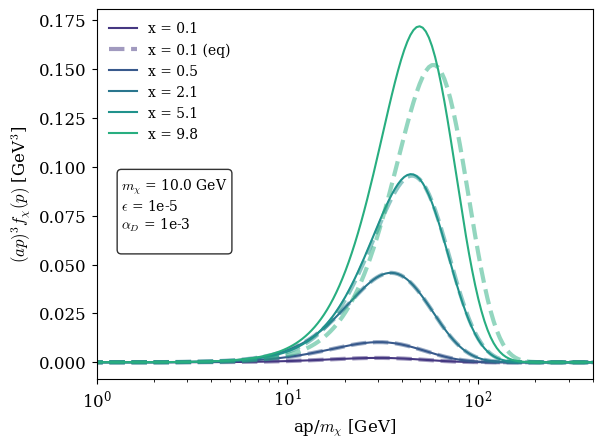

In [132]:
#indices = [0,  30, 60, 75, 85] # # indices of snapshots to plot
indices = [0, 7, 14, 18, 21] #, 30, 38] # # indices of snapshots to plot
p_tilde = grid.ptilde
cmap = plt.get_cmap("viridis")
palette = [cmap(i) for i in range(40, 300, 30)]
plt.figure()

for k, i in enumerate(indices):
    snap = ann_snaps[i]
    T = T_vals_ann[i]
    x = st_ann.species["chi"].mass_GeV / T
    p_phys = grid.p_phys(T)
    dist = p_tilde**3 * snap["chi"]
    normalized_dist = dist / np.trapezoid(dist, p_phys)
    plt.plot(p_tilde/st.species["chi"].mass_GeV, normalized_dist, label=f"x = {x:.1f}", color=palette[k])

    # plot eq distribution at that temp
    sp = st_ann.species["chi"]
    E_phys = np.sqrt(p_phys**2 + sp.mass_GeV**2)
    feq = np.exp(-E_phys / T)
    eq = p_tilde**3 * feq #/ (st_ann.number_density("chi", T))
    norm_eq = eq / np.trapezoid(eq, p_phys)
    if k == 0:
        label = f"x = {x:.1f} (eq)"
    else:
        label = None
    plt.plot(p_tilde/st.species["chi"].mass_GeV, norm_eq, linestyle="--", color=palette[k], label=label, alpha = 0.5, lw = 3)


# add text box with parameters in the bottom left
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
param_text = f"$m_\\chi$ = {chi.mass_GeV} GeV\n" + \
             f"$\\epsilon$ = 1e-5\n" + \
             f"$\\alpha_D$ = 1e-3\n"

plt.text(0.05, 0.35, param_text, transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom', bbox=props)
plt.xlabel("ap/$m_{\chi}$ [GeV]")
plt.ylabel("$(a p)^3 f_{\chi}(p)$ [GeV$^3$]")
plt.xlim(1, 4e2)
plt.xscale("log")
plt.legend(frameon=False, fontsize = 10)

In [113]:
# T_ref = grid.T_ref
# p0 = grid.p_phys(T_ref)

# st_ann2 = PhaseSpaceState(grid, [chi])
# st_ann2.ann_kernel = ann2_kernel_simp
# st_ann2.mpsi_GeV = ME
# st_ann2.Msq_const = xx_ee_m2(epsilon=1e-1, alphaD=1.0, mchi=chi.mass_GeV, mA=0.5*chi.mass_GeV)
# st_ann2.Nmu = 3#8
# st_ann2.Nt = 3#8

# st_ann2.set_initial_f("chi", np.exp(-p0 / (T_ref)))
# T_vals_ann2, ann_snaps2 = evolve_with_collisions(
#     state=st_ann2,
#     T_span=(T_ref, 0.10),
#     gstar_func=gstar_func,
#     collision_rhs=annihilation_collision_rhs1,
#     method="Radau",
#     rtol=1e-8,
#     atol=1e-10,
#     n_eval=150,
# )


<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:38: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:38: SyntaxWarning: invalid escape sequence '\c'
/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_20047/1600723839.py:37: SyntaxWarning: invalid escape sequence '\c'
  plt.xlabel("ap/$m_{\chi}$ [GeV]")
/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_20047/1600723839.py:38: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("$(a p)^3 f_{\chi}(p)$ [GeV$^3$]")


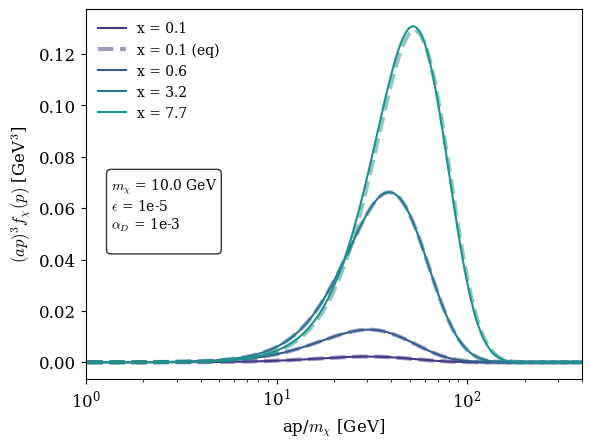

In [135]:
#indices = [0,  30, 60, 75, 85] # # indices of snapshots to plot
indices = [0, 10, 20, 25] # # indices of snapshots to plot
p_tilde = grid.ptilde
cmap = plt.get_cmap("viridis")
palette = [cmap(i) for i in range(40, 500, 30)]
plt.figure()

for k, i in enumerate(indices):
    snap = ann_snaps2[i]
    T = T_vals_ann2[i]
    x = st_ann2.species["chi"].mass_GeV / T
    p_phys = grid.p_phys(T)
    dist = p_tilde**3 * snap["chi"]
    normalized_dist = dist / np.trapezoid(dist, p_phys)
    plt.plot(p_tilde/st.species["chi"].mass_GeV, normalized_dist, label=f"x = {x:.1f}", color=palette[k])

    # plot eq distribution at that temp
    sp = st_ann2.species["chi"]
    E_phys = np.sqrt(p_phys**2 + sp.mass_GeV**2)
    feq = np.exp(-E_phys / T)
    eq = p_tilde**3 * feq #/ (st_ann.number_density("chi", T))
    norm_eq = eq / np.trapezoid(eq, p_phys)
    if k == 0:
        label = f"x = {x:.1f} (eq)"
    else:
        label = None
    plt.plot(p_tilde/st.species["chi"].mass_GeV, norm_eq, linestyle="--", color=palette[k], label=label, alpha = 0.5, lw = 3)


# add text box with parameters in the bottom left
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
param_text = f"$m_\\chi$ = {chi.mass_GeV} GeV\n" + \
             f"$\\epsilon$ = 1e-5\n" + \
             f"$\\alpha_D$ = 1e-3\n"

plt.text(0.05, 0.35, param_text, transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom', bbox=props)
plt.xlabel("ap/$m_{\chi}$ [GeV]")
plt.ylabel("$(a p)^3 f_{\chi}(p)$ [GeV$^3$]")
plt.xlim(1, 4e2)
plt.xscale("log")
plt.legend(frameon=False, fontsize = 10)

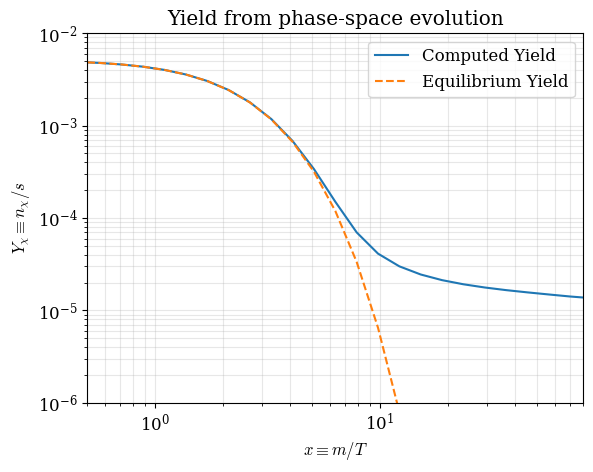

In [136]:
m_scale = st_ann.species["chi"].mass_GeV   # or choose a different reference mass

gstar_s_func = gstar_func
x_vals = m_scale / np.asarray(T_vals_ann)

tdep = False
Y_vals = np.zeros_like(x_vals, dtype=float)
Y_eq_vals = np.zeros_like(x_vals, dtype=float)
for k, T in enumerate(T_vals_ann):
    snap = ann_snaps[k]
    st_ann.f["chi"] = snap["chi"]

    n_chi = st_ann.number_density("chi", T)            # GeV^3
    s_T   = s_SM(T, t_dep = tdep)           # GeV^3
    Y_vals[k] = n_chi / s_T

    # now plot equilibrium yield for comparison
    n_chi_eq = neq_stable(m=chi.mass_GeV, g=chi.dof, T=T)  # GeV^3
    s_T_eq   = s_SM(T, t_dep = tdep)           # GeV^3
    Y_eq = n_chi_eq / s_T_eq
    Y_eq_vals[k] = Y_eq


# --- plot Y vs x ---
plt.figure()
plt.loglog(x_vals, Y_vals, label="Computed Yield")
plt.loglog(x_vals, Y_eq_vals, linestyle="--", label="Equilibrium Yield")
plt.xlabel(r"$x \equiv m/T$")
plt.ylabel(r"$Y_\chi \equiv n_\chi/s$")
plt.grid(True, which="both", alpha=0.3)
plt.title(r"Yield from phase-space evolution")
plt.ylim(10**-6, 1e-2)
plt.xlim(0.5, 80)
plt.legend()
plt.show()


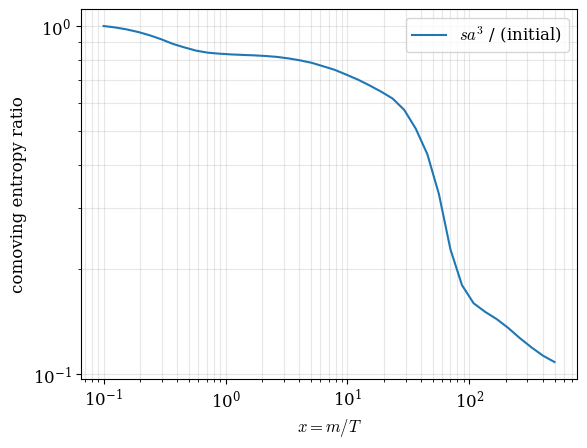

In [110]:
S_com = []
for T in T_vals_ann:
    a = st_ann.grid.a_of_T(T)
    S_com.append(s_SM(T) * a**3)

plt.figure()
plt.loglog(x_vals, np.abs(S_com)/np.abs(S_com[0]), label=r"$s a^3$ / (initial)")
plt.xlabel(r"$x=m/T$")
plt.ylabel("comoving entropy ratio")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.show()


In [111]:
print([float(x) for x in x_vals])

[0.1, 0.12440716249808177, 0.1547714208082412, 0.19254673298549857, 0.23954192699001675, 0.29800731436150657, 0.3707424438338889, 0.4612301545497855, 0.5738033478609051, 0.7138524633927497, 0.8880835941295778, 1.1048396000675884, 1.3744995965992417, 1.7099759466766962, 2.1273325546601902, 2.646554068150696, 3.29250282016383, 4.096109333735141, 5.09585339491897, 6.339606613680861, 7.8869247016210835, 9.811899229647093, 12.206705418775089, 15.186015845997678, 18.892491410514783, 23.503612489015268, 29.240177382128635, 36.37687499051213, 45.2554379811705, 56.301006268453406, 70.04248435644996, 87.13786733102222, 108.40574820786773, 134.8645153302234, 167.78111673912144, 208.73172654273492, 259.67721822507195, 323.0570588477637, 401.90612016226106, 500.0]


In [112]:
print([float(Y) for Y in Y_vals])

[0.005121446716685182, 0.005114545860884683, 0.005103940745091876, 0.005087711695562743, 0.005062978088979327, 0.005025512873258783, 0.00496922680112695, 0.004885591677524928, 0.004763133148764839, 0.004587272504984783, 0.004341046882630149, 0.004007468421639015, 0.0035742965262127785, 0.003041468025168988, 0.0024296854708243123, 0.0017858702876055552, 0.0011789337933277154, 0.0006809375998364246, 0.00033835490743720157, 0.00014994701745273142, 6.992153424432755e-05, 4.118223539733879e-05, 2.9996888765232e-05, 2.448383521235971e-05, 2.1268152594392814e-05, 1.918743226612569e-05, 1.770939858302862e-05, 1.6582499608786506e-05, 1.5677739501093406e-05, 1.4883047468173856e-05, 1.4147554187758923e-05, 1.357754886374662e-05, 1.3161658812434828e-05, 1.2854077629475069e-05, 1.2613578626573775e-05, 1.2419636261463364e-05, 1.2261663057367224e-05, 1.2134478022642068e-05, 1.2031748256040328e-05, 1.1949622108873922e-05]


Final relic abundance: Omega h^2 = 5.88e+03


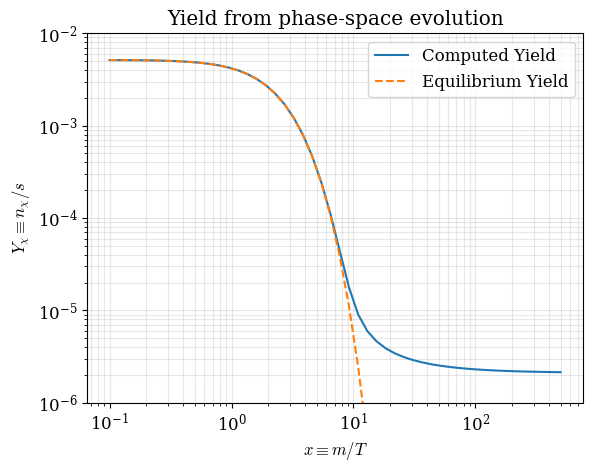

In [144]:

m_scale = st_ann2.species["chi"].mass_GeV   # or choose a different reference mass

gstar_s_func = gstar_const
x_vals = m_scale / np.asarray(T_vals_ann2)

Y_vals = np.zeros_like(x_vals, dtype=float)
Y_eq_vals = np.zeros_like(x_vals, dtype=float)
for k, T in enumerate(T_vals_ann2):
    snap = ann_snaps2[k]
    st_ann2.f["chi"] = snap["chi"]

    n_chi = st_ann2.number_density("chi", T)
    s_T   = s_SM(T, t_dep = False) #, gstar_s_func)
    Y_vals[k] = n_chi / s_T
    # OK, now plot equilibrium yield for comparison
    n_chi_eq = neq_stable(m=chi.mass_GeV, g=chi.dof, T=T)
    s_T_eq   = s_SM(T, t_dep = False)
    Y_eq = n_chi_eq / s_T_eq
    Y_eq_vals[k] = Y_eq

# --- plot Y vs x ---
omegah2 = get_relic_abundance(Y_vals[-1], m_scale)
print(f"Final relic abundance: Omega h^2 = {omegah2:.2e}")
plt.figure()
plt.loglog(x_vals, Y_vals, label="Computed Yield")
plt.loglog(x_vals, Y_eq_vals, linestyle="--", label="Equilibrium Yield")
plt.xlabel(r"$x \equiv m/T$")
plt.ylabel(r"$Y_\chi \equiv n_\chi/s$")
plt.grid(True, which="both", alpha=0.3)
plt.title(r"Yield from phase-space evolution")
plt.ylim(10**-6, 1e-2)
# plt.xlim(0.1, 400)
plt.legend()
plt.show()


In [140]:
print([float(v) for v in x_vals])

[0.1, 0.11898416954165636, 0.14157232601517625, 0.16844865640996376, 0.20042723493347345, 0.23847668102089797, 0.28374949846322023, 0.33761698432507753, 0.40171076503077763, 0.4779722177313052, 0.5687112739074311, 0.6766763863485316, 0.8051377787812902, 0.9579864997490565, 1.1398522810475966, 1.3562437706061097, 1.6137153874161265, 1.9200658524830008, 2.284574409229823, 2.718281888383306, 3.234325130694131, 3.8483348970335034, 4.578909318417071, 5.448177226584068, 6.482468428208699, 7.713111225104185, 9.17738133701449, 10.91963096951765, 12.992632226094093, 15.459175555819677, 18.393971653078783, 21.885914417143464, 26.04077351583579, 30.984398110040804, 36.86652877871272, 43.86533310618707, 52.19280231307794, 62.10117239273419, 73.89056424712714, 87.91807423908827, 104.60859051039608, 124.46766268802673, 148.09681479725867, 176.21176520416307, 209.66410546286681, 249.46709471193464, 296.8263509226927, 353.17636862616854, 420.2239692272256, 500.0]


In [141]:
print([float(v) for v in Y_vals])

[0.005121446716685182, 0.005116200051966785, 0.005108897408422641, 0.005098415463713566, 0.005083848904908784, 0.005063585242577952, 0.005035307042059468, 0.004996117846898971, 0.004942189489486665, 0.004868547066386164, 0.004768981936118895, 0.004636029908519604, 0.004461204461595675, 0.0042356353365428905, 0.00395128430115181, 0.0036028646189428678, 0.003190419938862857, 0.00272216077518353, 0.002216664550936277, 0.001703071174076923, 0.001217862061758625, 0.0007977103524855696, 0.00046990063266287514, 0.0002441462861984935, 0.00011036058143362672, 4.429244692363085e-05, 1.791974440421203e-05, 9.068572481116969e-06, 5.9891998255646685e-06, 4.631279282976715e-06, 3.8892799227526896e-06, 3.427719709289114e-06, 3.1168464860444644e-06, 2.896094370675965e-06, 2.7333894566765915e-06, 2.6101471141439683e-06, 2.5148488433296524e-06, 2.439977140678724e-06, 2.3804159336299344e-06, 2.332561291834894e-06, 2.2938041876625835e-06, 2.2622143436328265e-06, 2.2363301405034338e-06, 2.21502934403539e-0

In [13]:
## now let's add multiple species
from xsec_expressions import gammaA_ee


chi = PhaseSpaceSpecies(name="chi", mass_GeV=10.0, dof=2.0)
A = PhaseSpaceSpecies(name="A", mass_GeV=5.0, dof=3.0)
A.decay_width_GeV = gammaA_ee(mA= A.mass_GeV, epsilon=1e-8)
st_dec = PhaseSpaceState(grid, [chi, A])
st_dec.set_initial_f("chi", np.exp(-p0 / (T_ref*0.7)))
st_dec.set_initial_f("A", np.exp(-p0 / (T_ref*0.7)))
st_dec.g_const = False
st_dec.mf_GeV = ME

# g_star_func = gstar_interp
# #g_star_func = lambda T: 90
# T_span_dec = (100.0, 0.1) #0.02)  # GeV
# T_vals_dec, dec_snaps = evolve_with_collisions(
#     state=st_dec,
#     T_span= T_span_dec,
#     gstar_func=gstar_func,
#     collision_rhs=  decay_collision_rhs1,
#     method="Radau",
#     rtol=1e-8,
#     atol=1e-10,
#     n_eval=15,
# )

In [16]:

st_dec2 = PhaseSpaceState(grid, [chi, A])
st_dec2.set_initial_f("chi", np.exp(-p0 / (T_ref*0.7)))
st_dec2.set_initial_f("A", np.exp(-p0 / (T_ref*0.7)))
st_dec2.g_const = False
st_dec2.mf_GeV = ME

g_star_func = gstar_interp
#g_star_func = lambda T: 90
T_span_dec = (100.0, 0.1) #0.02)  # GeV
T_vals_dec, dec_snaps2 = evolve_with_collisions(
    state=st_dec2,
    T_span= T_span_dec,
    gstar_func=gstar_func,
    collision_rhs=  decay_collision_rhs1,
    method="Radau",
    rtol=1e-8,
    atol=1e-10,
    n_eval=20,
)

In [735]:
print(gammaA_ee(mA= A.mass_GeV, epsilon=1e-8))

1.2165450121654503e-18


<>:41: SyntaxWarning: invalid escape sequence '\G'
<>:41: SyntaxWarning: invalid escape sequence '\e'
<>:41: SyntaxWarning: invalid escape sequence '\G'
<>:41: SyntaxWarning: invalid escape sequence '\e'
/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_25844/120907337.py:41: SyntaxWarning: invalid escape sequence '\G'
  plt.text(0.02, 0.35, f"$\Gamma_A$ = {st_dec.species['A'].decay_width_GeV:.2e} GeV ($\epsilon$ = 1e-8)",
/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_25844/120907337.py:41: SyntaxWarning: invalid escape sequence '\e'
  plt.text(0.02, 0.35, f"$\Gamma_A$ = {st_dec.species['A'].decay_width_GeV:.2e} GeV ($\epsilon$ = 1e-8)",


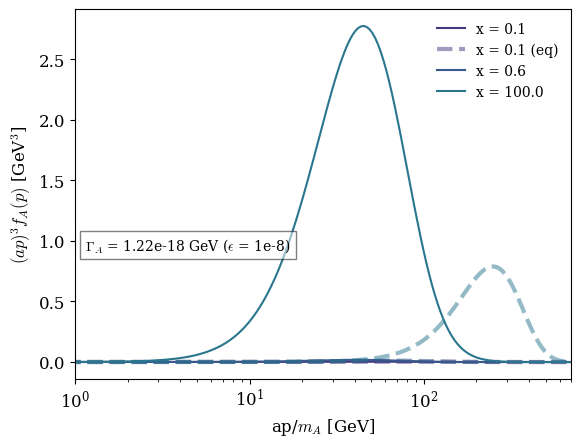

In [ ]:
indices = [0, 1, 4] #8, 16, 24, 28]  # indices of snapshots to plot
p_tilde = grid.ptilde
cmap = plt.get_cmap("Blues")
cmapA = plt.get_cmap("viridis")
palette = [cmap(i) for i in range(40, 200, 30)]
paletteA =  [cmapA(i) for i in range(40, 200, 30)]
plt.figure()

for k, i in enumerate(indices):
    snap = dec_snaps2[i]
    T = T_vals_dec[i]
    x = st_dec2.species["chi"].mass_GeV / T
    p_phys = grid.p_phys(T)
    # dist_chi = p_tilde**3 * snap["chi"]
    # normalized_dist_chi = dist_chi / np.trapezoid(dist_chi, p_phys)

    normalized_dist_A = p_tilde**3 * snap["A"] / np.trapezoid(p_tilde**3 * snap["A"], p_phys)
    #normalized_dist_A = p_tilde**3 * snap["A"] / st_dec.number_density("A", T)
    plt.plot(p_tilde/st_dec.species["A"].mass_GeV, normalized_dist_A, label=f"x = {x:.1f}", color=paletteA[k])
    #plt.plot(p_tilde/st_dec.species["A"].mass_GeV, normalized_dist_A, label=f"x = {x:.1f} (A)", color=paletteA[k])

    # plot eq distribution at that temp
    sp = st_dec.species["A"]
    E_phys = np.sqrt(p_phys**2 + sp.mass_GeV**2)
    feq = np.exp(-E_phys / T)
    eq = p_tilde**3 * feq #/ (st_ann.number_density("chi", T))
    norm_eq = eq / np.trapezoid(eq, p_phys)
    if k == 0:
        label = f"x = {x:.1f} (eq)"
    else:
        label = None
    plt.plot(p_tilde/st_dec.species["A"].mass_GeV, norm_eq, linestyle="--", color= paletteA[k], label=label, alpha = 0.5, lw = 3)


plt.xlabel("ap/$m_{A}$ [GeV]")
plt.ylabel("$(a p)^3 f_{A}(p)$ [GeV$^3$]")
plt.xlim(1, 7e2)
plt.xscale("log")

# add text box in bottom left with decay width info
plt.text(0.02, 0.35, f"$\Gamma_A$ = {st_dec.species['A'].decay_width_GeV:.2e} GeV ($\epsilon$ = 1e-8)",
         transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5, edgecolor='k'))
plt.legend(frameon=False, fontsize = 10)

Final relic abundance: Omega h^2 = -6.72e-07


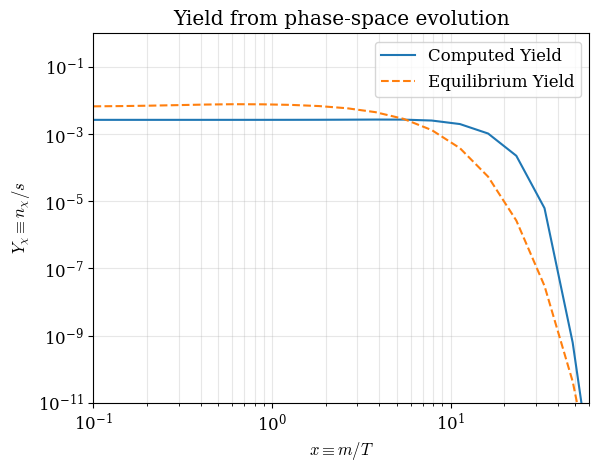

In [18]:
from functions import s_SM, neq_stable, get_relic_abundance
m_scale = st_dec.species["chi"].mass_GeV   # or choose a different reference mass

gstar_s_func = gstar_func
x_vals = m_scale / np.asarray(T_vals_dec)

Y_vals = np.zeros_like(x_vals, dtype=float)
Y_eq_vals = np.zeros_like(x_vals, dtype=float)
for k, T in enumerate(T_vals_dec):

    snap = dec_snaps2[k]
    st_dec.f["A"] = snap["A"]

    n_A = st_dec.number_density("A", T)
    # if n_A < 0:
    #     p_phys = grid.p_phys(T)

    #     test = number_density_test(p_phys, snap["A"])
    #     print("test n_A =", test)
    #     print("----")
    #print(n_A)
    s_T   = s_SM(T, t_dep = False) #, gstar_s_func)
    Y_vals[k] = n_A / s_T
    # OK, now plot equilibrium yield for comparison
    n_A_eq = neq_stable(m=A.mass_GeV, g=A.dof, T=T)
    s_T_eq   = s_SM(T, t_dep = True)
    Y_eq = n_A_eq / s_T_eq
    Y_eq_vals[k] = Y_eq

# --- plot Y vs x ---
omegah2 = get_relic_abundance(Y_vals[-1], m_scale)
print(f"Final relic abundance: Omega h^2 = {omegah2:.2e}")
plt.figure()
plt.loglog(x_vals, Y_vals, label="Computed Yield")
plt.loglog(x_vals, Y_eq_vals, linestyle="--", label="Equilibrium Yield")
plt.xlabel(r"$x \equiv m/T$")
plt.ylabel(r"$Y_\chi \equiv n_\chi/s$")
plt.grid(True, which="both", alpha=0.3)
plt.title(r"Yield from phase-space evolution")
plt.ylim(10**-11, 1)
plt.xlim(0.1, 60)
plt.legend()
plt.show()


In [19]:
print([float(v) for v in x_vals])


[0.1, 0.14384498882876628, 0.20691380811147903, 0.29763514416313175, 0.4281332398719394, 0.6158482110660264, 0.8858667904100823, 1.2742749857031335, 1.8329807108324359, 2.636650898730358, 3.79269019073225, 5.455594781168517, 7.847599703514611, 11.288378916846883, 16.23776739188721, 23.357214690901213, 33.59818286283781, 48.32930238571752, 69.51927961775606, 100.0]


In [20]:
print([float(v) for v in Y_vals])

[0.002641535811542761, 0.0026415415635797942, 0.002641558953308998, 0.002641611534738132, 0.0026417690014544494, 0.0026422273970805716, 0.0026435046055085336, 0.002646888032623679, 0.00265506320070293, 0.002671697767835687, 0.0026942005975006005, 0.002685426082924607, 0.0025193289940620037, 0.0019794053058952332, 0.0010343040823789075, 0.0002251199029144207, 6.219242333949267e-06, 6.193355125570574e-10, 1.004774204854762e-15, -2.451215264224124e-16]


In [588]:
def number_density_test(p, f_p):
        """
        n = g/(2pi^2) int( dp p^2 f(p))
        """
        integrand = p**2 * f_p
        print(f_p)
        n = sp.dof / (2.0 * np.pi**2) * np.trapezoid(integrand, p)
        return n
# t = 0.047695336204179595
# p_phys = grid.p_phys(t)
# f_t = dec_snaps[-1].index_of(t)
# n_t = number_density_test(p_phys, snap["A"], st_dec, "A", T)